In [4]:
import numpy as np
import timeit

In [2]:
np.array([[1,2]]).shape

(1, 2)

In [19]:
import numpy as np

num_iters = 100  # Example number of iterations
iter_indices = np.logspace(
    0,
    np.log10(np.array(num_iters, dtype=np.int64)),
    num=min(10, num_iters),
    dtype=np.int64,
)
iter_indices = list(dict.fromkeys(np.insert(iter_indices, 0, 0)))
print(iter_indices)

[np.int64(0), np.int64(1), np.int64(2), np.int64(4), np.int64(7), np.int64(12), np.int64(21), np.int64(35), np.int64(59), np.int64(100)]


In [1]:
import numpy as np

np.random.seed(43)

# Example inputs
G, K, N = 3, 4, 5  # Example dimensions
Y = np.random.rand(G, N)  # Shape (G, N)
B = np.random.rand(G, K)  # Shape (G, K)
Omega = np.random.rand(K, N)  # Shape (K, N)
k = 1  # Example index for `k` to exclude

# Exclude the k-th column of B and the k-th row of Omega
B_excluded = np.delete(B, k, axis=1)  # Shape (G, K-1)
Omega_excluded = np.delete(Omega, k, axis=0)  # Shape (K-1, N)

# Compute the summation using einsum
excluded_sum = np.einsum("gt,tn->gn", B_excluded, Omega_excluded)  # Shape (G, N)

# Subtract from Y
result = (Y - excluded_sum).T  # Shape (N, G)

In [2]:
sum_B_Omega = np.zeros((G, N))  # Initialize the sum to a zero matrix
for t in range(K):
    if t != k:  # Exclude the k-th term
        sum_B_Omega += np.expand_dims(B[:, t], 1) @ np.expand_dims(
            Omega[t].T, 0)
result2 = (Y - sum_B_Omega).T

In [19]:
result2

array([[-0.31557624, -0.74094336, -0.88446055],
       [ 0.45878818,  0.05471392,  0.3924876 ],
       [-0.02997689, -0.09809144, -0.16898354],
       [-0.08292189, -1.00735083, -0.6090193 ],
       [ 0.0081116 , -0.47007712, -0.00170847]])

In [20]:
result

array([[-0.31557624, -0.74094336, -0.88446055],
       [ 0.45878818,  0.05471392,  0.3924876 ],
       [-0.02997689, -0.09809144, -0.16898354],
       [-0.08292189, -1.00735083, -0.6090193 ],
       [ 0.0081116 , -0.47007712, -0.00170847]])

In [50]:
code_to_time = """import numpy as np # Assuming W is an (n x K) matrix and Sigma is a (G,) vector.
W = np.random.rand(1000, 8)  # Example matrix of shape (n, K)
Sigma = np.random.rand(5000)  # Example vector of length G

# Using Einstein summation convention to compute A:
A = np.einsum("ik,j->jk", W**2, 1 / (2 * Sigma**2))
"""
execution_time = timeit.timeit(code_to_time, number=1)  # Runs once
print(f"Execution time: {execution_time:.4f} seconds")

Execution time: 0.0325 seconds


In [5]:
import torch

n, K, G = 4, 3, 5

lambda1 = 20
lambda0 = 0.1

Omega = torch.rand(K, n, device="mps")  # W: shape (n, K)
Sigma = torch.rand(G, device="mps")  # Sigma: shape (G,)
Y = torch.rand(G, n, device="mps")  # Y: shape (n, G)
B = torch.rand(G, K, device="mps")
Gamma = torch.randint(0, 2, (G, K), device="mps")

# Compute a
a = torch.einsum("ki,j->jk", Omega**2, 1 / (2 * Sigma))

# Compute b
mask = 1 - torch.eye(K, device="mps")
excluded_sum = torch.einsum("jl,li,lk->jik", B, Omega, mask)  # Shape (G, K)
b = torch.einsum(
    "ki, jik -> jk", Omega, Y.unsqueeze(2).repeat(1, 1, K) - excluded_sum
) / (Sigma).unsqueeze(1)
# Compute c
c = lambda1 * Gamma + lambda0 * (1 - Gamma)

# Vectorized sampling from truncated normal mixture
mu_pos = ((b - c) / (2 * a)).to(device="cpu")
mu_neg = ((b + c) / (2 * a)).to(device="cpu")
sigma = torch.sqrt(1 / (2 * a)).to(device="cpu")

In [32]:
tensor = torch.tensor([0.00001, 0.0005, 1e-10], dtype=torch.float32)
print(tensor)  # May round very small values

tensor([1.0000e-05, 5.0000e-04, 1.0000e-10])


In [29]:
mu_pos

tensor([[ -5.5756, -53.7743,  -0.3184],
        [  0.1367, -31.3893,   0.5064],
        [ -4.9973, -52.3613,  -3.6697],
        [ -0.3341, -92.7929,  -6.2562],
        [ -0.5446,  -2.7203,  -0.6445]])

In [22]:
b

tensor([[-14.3531,  -7.9710,  -6.7695],
        [ -9.4418,  -5.3623,  -4.4889],
        [ -8.1689,  -6.9152,  -2.6723],
        [ -4.9878,  -5.0868,  -1.4321],
        [-21.6502, -14.8842,  -9.0969]], device='mps:0')

In [11]:
Sigma.shape

torch.Size([5])

In [7]:
b.shape

torch.Size([5, 3])

In [8]:
(Sigma**2).unsqueeze(0)

tensor([[0.4023, 0.6909, 0.7396, 0.0514, 0.2755]], device='mps:0')

In [3]:
excluded_sum.shape

torch.Size([5, 4])

In [18]:
epsilon = 1e-10
Omega = torch.rand(K, n, device="mps") + epsilon

In [19]:
Omega[2,1] = 2

In [231]:
mu_pos

tensor([[  0.8045,   4.2395,  -8.4261],
        [ -0.2703,  -4.1558,  -0.7065],
        [ -5.0574,   0.4732, -10.9034],
        [  0.3610,   1.4759,  -0.9909],
        [ -1.5673, -12.3967,  -3.9729]])

In [178]:
B_new = torch.empty_like(B, device="cpu")

In [181]:
B_new.shape

torch.Size([5, 3])

In [242]:
code_to_time = """import torch

# Dimensions
n, K, G = 1000, 8, 2000

lambda1 = 20
lambda0 = 0.1

Omega = torch.rand(K, n, device="mps")  # W: shape (n, K)
Sigma = torch.rand(G, device="mps")  # Sigma: shape (G,)
Y = torch.rand(n, G, device="mps")  # Y: shape (n, G)
B = torch.rand(G, K, device="mps")
Gamma = torch.randint(0, 2, (G, K), device="mps")

# Compute a
a = torch.einsum("ki,j->jk", Omega**2, 1 / (2 * Sigma**2))

# Compute b
mask = 1 - torch.eye(K, device="mps")
excluded_sum = torch.einsum(
    "jl,li,lk->jk", B, Omega, mask
)  # Shape (G, K)
b = (Y.sum(dim=0, keepdim=True).T - excluded_sum) / (
    Sigma**2
).unsqueeze(1)

# Compute c
c = lambda1 * Gamma + lambda0 * (1 - Gamma)

# Vectorized sampling from truncated normal mixture
mu_pos = ((b - c) / (2 * a)).to(device="cpu")
mu_neg = ((b + c) / (2 * a)).to(device="cpu")
sigma = torch.sqrt(1 / (2 * a)).to(device="cpu")

B_new = torch.empty_like(B, device="cpu")
"""

execution_time = timeit.timeit(code_to_time, number=1)  # Runs once
print(f"Execution time: {execution_time:.4f} seconds")

Execution time: 0.0053 seconds


In [86]:
code_to_time = """import torch # Assuming W is an (n x K) matrix and Sigma is a (G,) vector.

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

W = torch.rand(1000, 8, device=device)  # Example matrix of shape (n, K)
Sigma = torch.rand(50000, device=device)  # Example vector of length G

# Using Einstein summation convention to compute A:
A = torch.einsum("ik,j->jk", W**2, 1 / (2 * Sigma**2))
"""
execution_time = timeit.timeit(code_to_time, number=1)  # Runs once
print(f"Execution time: {execution_time:.4f} seconds")

Execution time: 0.0031 seconds


In [1]:
import torch

if torch.backends.mps.is_available():
    print("MPS backend is available for GPU acceleration on Mac!")
else:
    print("MPS backend is not available.")

MPS backend is available for GPU acceleration on Mac!


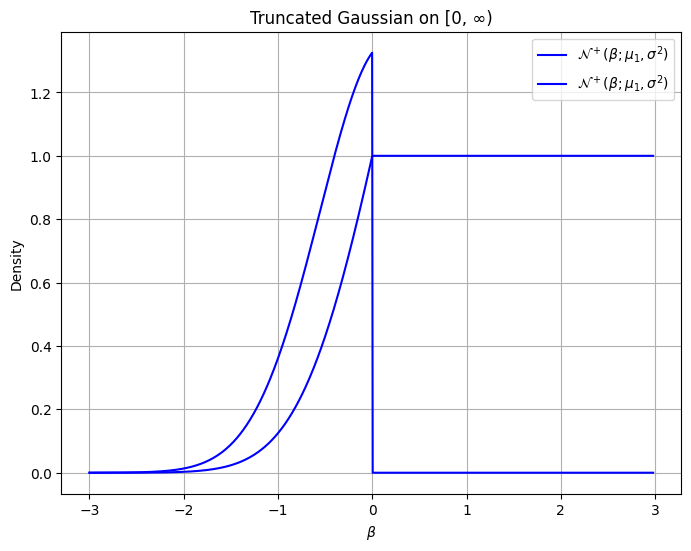

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm, beta, bernoulli

# Parameters
a = 1.0  # Parameter from density
b = 0.5  # Linear coefficient in beta
c = 0.2  # Absolute value coefficient

# Mean and standard deviation of the Gaussian
mu_1 = (b - c) / (2 * a)
sigma = np.sqrt(1 / (2 * a))

# Truncation bounds for the positive part (beta >= 0)
lower_bound = -np.inf
upper_bound = 0
# Convert bounds to standard normal units
a_param = (lower_bound - mu_1) / sigma
b_param = (upper_bound - mu_1) / sigma

# Generate the truncated normal distribution
x = np.linspace(-3, mu_1 + 4 * sigma, 1000)  # Points in the positive range
trunc_dist = truncnorm(a_param, b_param, loc=mu_1, scale=sigma)

# PDF of the truncated normal
pdf = trunc_dist.pdf(x)
cdf = trunc_dist.cdf(x)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(x, pdf, label=r"$\mathcal{N}^+(\beta; \mu_1, \sigma^2)$", color="blue")
plt.plot(x, cdf, label=r"$\mathcal{N}^+(\beta; \mu_1, \sigma^2)$", color="blue")
plt.title("Truncated Gaussian on [0, ∞)")
plt.xlabel(r"$\beta$")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()

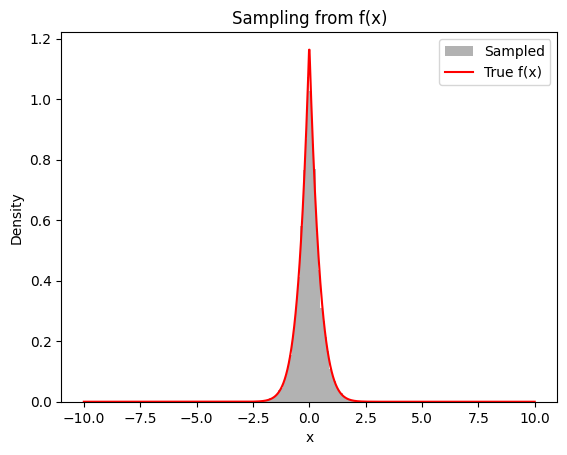

In [5]:
import numpy as np
from scipy.stats import norm

# Parameters for the distributions
mu1, sigma = - 2, 1.0  # Mean and std for q(x)
mu2 = 2  # Mean for p(x)

# Step 1: Compute the weights
# C_q and C_p are the probabilities of sampling from q(x) and p(x), respectively
C_q = (1 - norm.cdf(0, loc=mu1, scale=sigma))
C_p = (norm.cdf(0, loc=mu2, scale=sigma))
C = C_q + C_p
w_q = C_q / C
w_p = C_p / C


# Step 2: Sampling function
def sample_f(n_samples):
    samples = []
    for _ in range(n_samples):
        # Step 2.1: Choose q(x) or p(x) based on the weights
        if np.random.rand() < w_q:
            # Sample from q(x), truncated to x > 0
            u = np.random.rand()
            x = mu1 + sigma * norm.ppf(
                norm.cdf(0, loc=mu1, scale=sigma)
                + u * (1 - norm.cdf(0, loc=mu1, scale=sigma))
            )
        else:
            # Sample from p(x), truncated to x < 0
            u = np.random.rand()
            x = mu2 + sigma * norm.ppf(u * norm.cdf(0, loc=mu2, scale=sigma))
        samples.append(x)
    return np.array(samples)


# Generate samples
n_samples = 10000
samples = sample_f(n_samples)

# Visualization
import matplotlib.pyplot as plt

x = np.linspace(-10, 10, 1000)
f_x = np.where(x > 0, norm.pdf(x, mu1, sigma), norm.pdf(x, mu2, sigma))/ C
plt.hist(samples, bins=50, density=True, alpha=0.6, color="gray", label="Sampled")
plt.plot(x, f_x, label="True f(x)", color="red")  # Scaled for comparison
plt.legend()
plt.xlabel("x")
plt.ylabel("Density")
plt.title("Sampling from f(x)")
plt.show()

In [143]:
import torch
import torch.distributions as dist


class TruncNormMixture:
    def __init__(
        self,
        mu_pos: float,
        mu_neg: float,
        sigma: float,
        epsilon: float = 1e-10,
        device="mps",
    ):
        """Initializes the truncated normal mixture model.

        Args:
            mu_pos (float): Mean of the positive component of the mixture.
            mu_neg (float): Mean of the negative component of the mixture.
            sigma (float): Standard deviation of both components.
            epsilon (float, optional): Small value to avoid division by zero. Defaults to 1e-10.
            device (str, optional): The device to run computations on. Defaults to 'cuda'.
        """
        self.mu_pos = mu_pos
        self.mu_neg = mu_neg
        self.sigma = sigma
        self.device = device

        # Precompute the Z and w values
        self.Z_pos = 1 - torch.distributions.Normal(self.mu_pos, self.sigma).cdf(
            torch.tensor(0.0, device=device)
        )
        self.Z_neg = torch.distributions.Normal(self.mu_neg, self.sigma).cdf(
            torch.tensor(0.0, device=device)
        )
        self.Z = self.Z_pos + self.Z_neg + epsilon
        self.w_pos = (self.Z_pos + epsilon / 2) / self.Z
        self.w_neg = (self.Z_neg + epsilon / 2) / self.Z

    def _pdf(self, x: torch.Tensor) -> torch.Tensor:
        """Compute the PDF of the mixture at the given points."""
        pos_pdf = torch.distributions.Normal(self.mu_pos, self.sigma).log_prob(x)
        neg_pdf = torch.distributions.Normal(self.mu_neg, self.sigma).log_prob(x)
        return torch.exp(torch.where(x > 0, pos_pdf, neg_pdf)) / self.Z

    def _cdf(self, x: torch.Tensor) -> torch.Tensor:
        """Compute the CDF of the mixture at the given points."""
        if torch.any(x < 0):
            return (
                self.w_neg
                * torch.distributions.Normal(self.mu_neg, self.sigma).cdf(x)
                / self.Z_neg
            )
        else:
            return (
                self.w_neg
                + self.w_pos
                * (
                    torch.distributions.Normal(self.mu_pos, self.sigma).cdf(x)
                    - torch.distributions.Normal(self.mu_pos, self.sigma).cdf(
                        torch.tensor(0.0, device=self.device)
                    )
                )
                / self.Z_pos
            )

    def rvs(self, size: int = 1) -> torch.Tensor:
        """Generate random samples from the truncated normal mixture."""
        # Sample the component (positive or negative)
        component = (
            torch.randint(0, 2, (size,), device=self.device) * 2 - 1
        )  # Randomly choose 1 or -1

        samples = []
        for c in component:
            if c > 0:
                # Truncated normal sample for the positive component
                trunc_norm_pos = dist.TruncatedNormal(
                    self.mu_pos, self.sigma, low=self.mu_pos
                )
                sample = trunc_norm_pos.sample()
            else:
                # Truncated normal sample for the negative component
                trunc_norm_neg = dist.TruncatedNormal(
                    self.mu_neg, self.sigma, high=self.mu_neg
                )
                sample = trunc_norm_neg.sample()
            samples.append(sample)

        return torch.stack(samples)  # Stack all samples into a tensor


# Example usage:
mu_pos = 2.0
mu_neg = -2.0
sigma = 1.0
epsilon = 1e-10
device = "mps"

model = TruncNormMixture(mu_pos, mu_neg, sigma, epsilon, device)
samples = model.rvs(size=10)
print(samples)

AttributeError: module 'torch.distributions' has no attribute 'TruncatedNormal'

Transfer time: 3.6802937984466553 seconds


In [6]:
theta = 0.014
lambda0 = 20
lambda1 = 0.1

B = 0

p = (lambda1 * np.exp(-lambda1*B)* theta)/(lambda0*np.exp(-lambda0*B)*(1-theta)+ lambda1*np.exp(-lambda1*B)*theta)
p

np.float64(7.098887502915615e-05)

In [11]:
# Define the size of the blocks
block1_size = 5  # Size of the first block (tridiagonal)
block2_size = 3  # Size of the second block (identity)

# Create the first block: tridiagonal symmetric matrix
main_diag_block1 = np.full(block1_size, 501)
off_diag_block1 = np.full(block1_size - 1, 136)
block1 = (
    np.diag(main_diag_block1)
    + np.diag(off_diag_block1, k=1)
    + np.diag(off_diag_block1, k=-1)
)

# Create the second block: identity matrix
block2 = np.eye(block2_size)

# Combine the two blocks into a single matrix
matrix_combined = np.block(
    [
        [block1, np.zeros((block1_size, block2_size))],
        [np.zeros((block2_size, block1_size)), block2],
    ]
)

# Calculate the inverse of the combined matrix
inverse_combined = np.linalg.inv(matrix_combined)

# Display the combined matrix and its inverse
matrix_combined, inverse_combined

(array([[501., 136.,   0.,   0.,   0.,   0.,   0.,   0.],
        [136., 501., 136.,   0.,   0.,   0.,   0.,   0.],
        [  0., 136., 501., 136.,   0.,   0.,   0.,   0.],
        [  0.,   0., 136., 501., 136.,   0.,   0.,   0.],
        [  0.,   0.,   0., 136., 501.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]]),
 array([[ 2.16981375e-03, -6.40269788e-04,  1.88827156e-04,
         -5.53361307e-05,  1.50213848e-05,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [-6.40269788e-04,  2.35864091e-03, -6.95605919e-04,
          2.03848540e-04, -5.53361307e-05,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 1.88827156e-04, -6.95605919e-04,  2.37366230e-03,
         -6.95605919e-04,  1.88827156e-04,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [-5.53361307e-05,  2.03848540e-04,

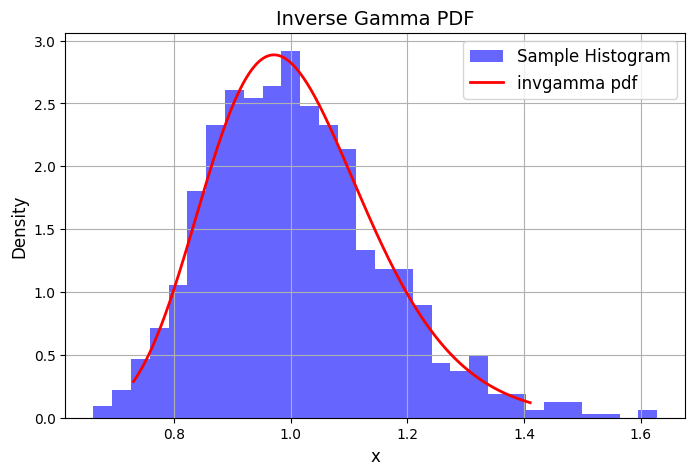

array([0.78212493, 1.19189123, 0.91183229, 1.22153365, 1.21119035,
       0.83906893, 1.1363685 , 0.97597515, 0.82707306, 1.01603784])

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import invgamma

# Parameters
a = 50.5
b = 50

# Create the x values (range for plotting the PDF)
x = np.linspace(invgamma.ppf(0.01, a, scale=b), invgamma.ppf(0.99, a, scale=b), 1000)

# Calculate the PDF
pdf = invgamma.pdf(x, a, scale=b)
samples = invgamma.rvs(a, scale=b, size=1000)

# Plot the PDF
plt.figure(figsize=(8, 5))
plt.hist(
    samples, bins=30, density=True, alpha=0.6, color="blue", label="Sample Histogram"
)
plt.plot(x, pdf, "r-", lw=2, label="invgamma pdf")
plt.title("Inverse Gamma PDF", fontsize=14)
plt.xlabel("x", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(loc="best", fontsize=12)
plt.grid()
plt.show()

# Sampling from the distribution


# Display first few samples
samples[:10]

In [20]:
bernoulli(np.array([1, 1])).rvs()

array([1, 1])

In [21]:
# Example dimensions
J = 5  # number of variables
K = 3  # number of factors
n = 4  # number of observations

# Random data for Omega (K x n) and Sigma (J)
Omega = np.random.rand(K, n)  # Omega matrix (K x n)
Sigma = np.random.rand(J)  # Sigma vector (J,)

# Step 1: Compute Omega_squared (element-wise square of Omega)
Omega_squared = Omega**2  # Shape: (K, n)

# Step 2: Sum along the 'i' dimension (axis 1), resulting in a (K,) array
Omega_sum = np.sum(Omega_squared, axis=1)  # Shape: (K,)

# Step 3: Compute a_{jk} for each j and k using broadcasting
Sigma_squared = Sigma**2  # Shape: (J,)
a = Omega_sum / (2 * Sigma_squared[:, np.newaxis])  # Broadcast over J and K

# Output the result
print("Omega (K x n):")
print(Omega)
print("\nSigma (J,):")
print(Sigma)
print("\nComputed a (J x K):")
print(a)

Omega (K x n):
[[0.33676365 0.69068196 0.00341501 0.26899532]
 [0.4653453  0.90384915 0.9937813  0.29644952]
 [0.70592413 0.01002473 0.81641525 0.8942615 ]]

Sigma (J,):
[0.74377532 0.60034137 0.9765629  0.99521911 0.33866176]

Computed a (J x K):
[[0.59907756 1.90615199 1.77572375]
 [0.91953875 2.92579915 2.72560166]
 [0.34750906 1.10570839 1.03005041]
 [0.33460248 1.0646421  0.99179408]
 [2.8895768  9.19408931 8.56498475]]


In [22]:
import numpy as np

# Example dimensions
n = 1956  # number of data points
J = 100  # number of variables (rows of Y and B)
K = 8  # number of factors (columns of B)
Y = np.random.rand(n, J)  # Y (n x J)
Omega = np.random.rand(K, n)  # Omega (K x n)
B = np.random.rand(J, K)  # B (J x K)
sigma_squared = np.random.rand(J)  # sigma^2 (J,)

# Step 1: Compute B * Omega^T (J x n matrix)
B_omega = np.dot(B, Omega)  # Shape: (J, n)

# Step 2: Compute the matrix of excluded terms (this is the "adjustment" for each k)
# Create a (J, K, n) matrix of B values, where each slice (k-th column) is broadcasted with Omega[k, :]
B_omega_exclusion = np.einsum("jk,ik->jki", B, Omega)  # Shape: (J, K, n)

# Step 3: Adjust the B_omega matrix by removing the contribution of the k-th column
# For each k, we remove the corresponding column in B_omega
B_omega_adjusted = B_omega_exclusion.sum(
    axis=1
)  # sum over axis 1 (k-axis), remove the contribution of each column

# Step 4: Compute the numerator for b_{jk}, which is Omega_k^T * (Y - B_omega_adjusted)
numerator = np.dot(Omega, (Y - B_omega_adjusted).T)  # Shape: (K, J)

# Step 5: Divide by sigma_j^2 to get b_{jk}
b_matrix = numerator.T / sigma_squared  # Shape: (J, K)

# Final result: b_matrix contains all b_{jk} for j=1,...,J and k=1,...,K
print("b_matrix shape:", b_matrix.shape)

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (100,8)->(100,8,newaxis) (8,1956)->(1956,8) 

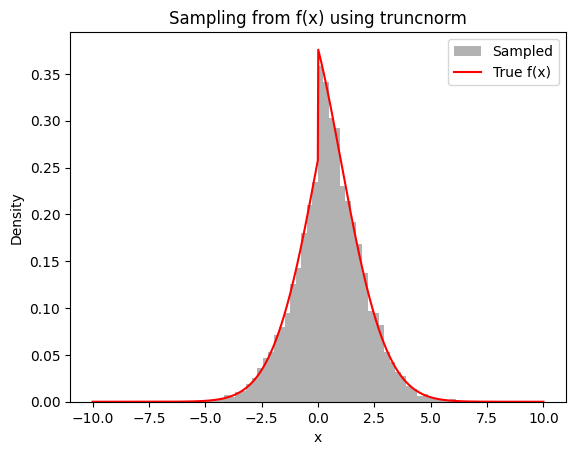

In [5]:
import numpy as np
from scipy.stats import truncnorm, norm
import matplotlib.pyplot as plt

# Parameters for the distributions
mu1, sigma = - 1.0, 2.0  # Mean and std for q(x)
mu2 = 2.0  # Mean for p(x)

# Step 1: Compute the weights
# Calculate the cumulative probabilities for truncation
C_q =  (1 - norm.cdf(0, loc=mu1, scale=sigma))
C_p = norm.cdf(0, loc=mu2, scale=sigma)
C = C_q + C_p
w_q = C_q / C
w_p = C_p / C


# Step 2: Define a sampling function
def sample_f(n_samples):
    samples = []
    for _ in range(n_samples):
        # Step 2.1: Choose q(x) or p(x) based on the weights
        if np.random.rand() < w_q:
            # Sample from q(x), truncated to x > 0
            a, b = (
                0 - mu1
            ) / sigma, np.inf  # Truncation bounds in standard normal space
            samples.append(truncnorm.rvs(a, b, loc=mu1, scale=sigma))
        else:
            # Sample from p(x), truncated to x < 0
            a, b = (
                -np.inf,
                (0 - mu2) / sigma,
            )  # Truncation bounds in standard normal space
            samples.append(truncnorm.rvs(a, b, loc=mu2, scale=sigma))
    return np.array(samples)


# Generate samples
n_samples = 10000
samples = sample_f(n_samples)

# Visualization
x = np.linspace(-10, 10, 1000)
f_x = np.where(x > 0, norm.pdf(x, mu1, sigma), norm.pdf(x, mu2, sigma))/C
plt.hist(samples, bins=50, density=True, alpha=0.6, color="gray", label="Sampled")
plt.plot(x, f_x, label="True f(x)", color="red")  # Scaled for comparison
plt.legend()
plt.xlabel("x")
plt.ylabel("Density")
plt.title("Sampling from f(x) using truncnorm")
plt.show()

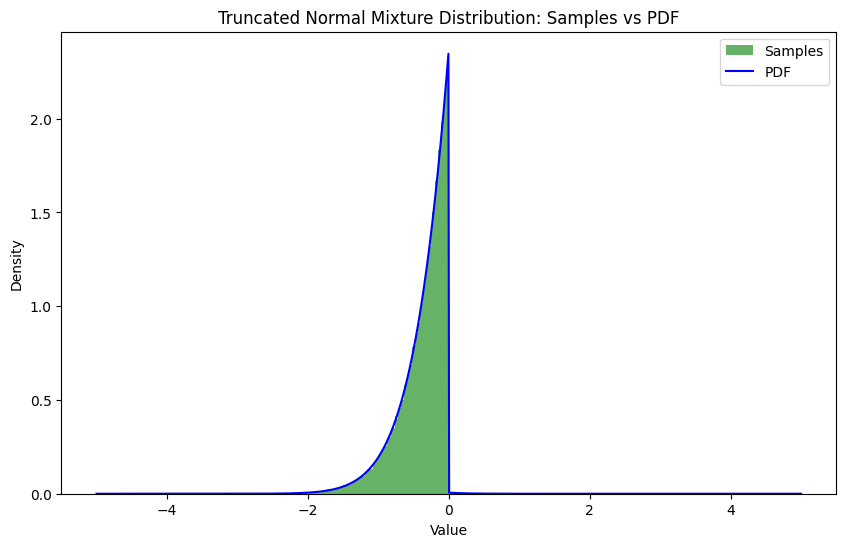

In [5]:
from src.utils.probability.density import trunc_norm_mixture
# Example usage:
mu_pos = -4
mu_neg = 2
sigma = np.sqrt(1)

# Initialize the distribution
dist = trunc_norm_mixture(
    mu_pos=mu_pos, mu_neg=mu_neg, sigma=sigma
)

# Generate 1000 samples
samples = dist.rvs(size=100000)

x_vals = np.linspace(-5, 5, 1000)
pdf_vals = np.array([dist._pdf(x) for x in x_vals])

plt.figure(figsize=(10, 6))

# Histogram of the samples
plt.hist(samples, bins=200, density=True, alpha=0.6, color="g", label="Samples")

# Plot the PDF
plt.plot(x_vals, pdf_vals, "b-", label="PDF")

# Labels and title
plt.title("Truncated Normal Mixture Distribution: Samples vs PDF")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()

plt.show()

In [11]:
dist.rvs()[0]

np.float64(-0.6018514907301018)

In [31]:
Omega = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
Omega[[0],:]**2

np.int64(14)

In [7]:
# Example matrices
G, n, K = 3, 4, 5  # G: variables, n: samples, K: factors
Y = np.random.rand(G, n)  # Observed data, shape (G, n)
B = np.random.rand(G, K)  # Loadings matrix, shape (G, K)
Omega = np.random.rand(K, n)  # Factors matrix, shape (K, n)

# Target indices (j, k)
j = 0  # Row index in B and Y
k = 1  # Column index in B, Row index in Omega

# Exclude the k-th column from B and the k-th row from Omega
mask = np.ones(K, dtype=bool)
mask[k] = False

# Compute the inner product (∑_{l ≠ k} B[j, l] * Omega[l, :])
inner_product = B[j, mask] @ Omega[mask, :]  # Shape (n,)

# Compute the adjusted Y[j, :]
adjusted_y = Y[j, :] - inner_product  # Shape (n,)

# Compute the final b_{jk} (∑_{i} Omega[k, i] * adjusted_y[i])
bjk = np.dot(Omega[k, :], adjusted_y)

print("b_{jk} =", bjk)

b_{jk} = -0.26813055834077415


In [8]:
alpha = 10
Gamma = np.random.rand(G, K)

for k in range(K):
    alphak = np.sum(Gamma[:, k]) + alpha * (k == (K - 1))
    print(alphak)

1.225371098802349
0.9690833673790553
1.4053629170677404
1.4821503003162049
11.250145453176867


a:0, b:0.5, alpha:500, beta:1457, cdf_a:0.0, cdf_b:1.0


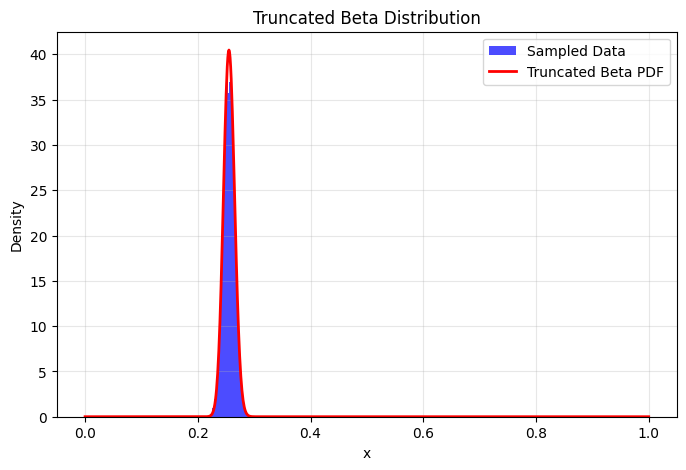

In [9]:
from src.utils.probability.density import truncated_beta

# Instantiate the truncated beta distribution
trunc_beta = truncated_beta(name="truncated_beta")

# Parameters for the distribution
alpha = 500
beta_param = 1457
a = 0
b = 0.5
size = 10000
# a:0.5, b:1, alpha:500.0000000001, beta:1457, cdf_a:1.0, cdf_b:1.0
# Generate samples
samples = trunc_beta._rvs(alpha, beta_param, a, b, size=size)

# Plot histogram of samples
x = np.linspace(0,1, 1000)

#pdf_values = beta.pdf(x, alpha, beta_param)
pdf_values = trunc_beta._pdf(x, alpha, beta_param, a, b)
#cdf_values = beta.cdf(x, alpha, beta_param)
cdf_values = trunc_beta._cdf(x, alpha, beta_param, a, b)

plt.figure(figsize=(8, 5))
plt.hist(samples, bins=100, density=True, alpha=0.7, color="blue", label="Sampled Data")
plt.plot(x, pdf_values, "r-", label="Truncated Beta PDF", linewidth=2)
#plt.plot(x, cdf_values, "r-", label="Truncated Beta CDF", linewidth=2)
plt.xlabel("x")
plt.ylabel("Density")
plt.title("Truncated Beta Distribution")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [7]:
(0.1 * np.exp(-0.1 * 0) * 0.5) / (0.1 * np.exp(-0.1 * 0) * 0.5 + 20 * np.exp(-20 * 0) * 0.5)

np.float64(0.004975124378109453)

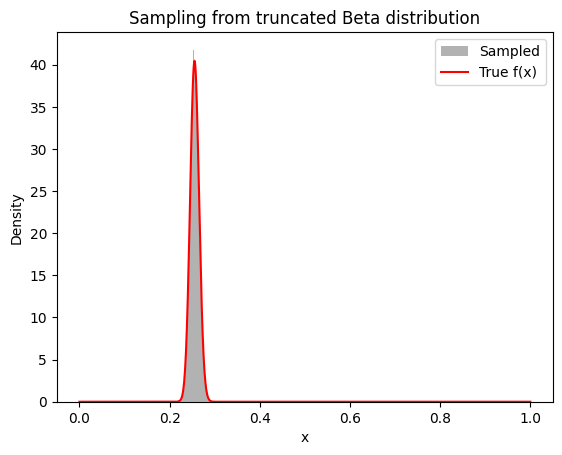

In [17]:
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt

# Parameters for the Beta distribution
alpha = 500
beta_param = 1957 - alpha
a, b = 0.1, 1  # Truncation bounds


# Step 1: Define a sampling function
def sample_truncated_beta(alpha, beta_param, a, b, n_samples):
    # Compute the cumulative probabilities for truncation
    C_a = beta.cdf(a, alpha, beta_param)  # CDF at the lower bound
    C_b = beta.cdf(b, alpha, beta_param)  # CDF at the upper bound
    C = C_b - C_a
    # Sample from the truncated Beta distribution
    samples = []
    for _ in range(n_samples):
        # Generate a uniform random number in [C_a, C_b]
        u = np.random.uniform(C_a, C_b)
        # Use the inverse CDF (percent point function) to generate a sample
        x = beta.ppf(u, alpha, beta_param)
        samples.append(x)
    return np.array(samples), C


# Step 2: Generate samples
n_samples = 10000
samples, C = sample_truncated_beta(alpha, beta_param, a, b, n_samples)

# Step 3: Visualization
x = np.linspace(0, 1, 1000)
f_x = beta.pdf(x, alpha, beta_param)  # Untruncated Beta PDF
f_x_truncated = np.where((x > a) & (x < b), f_x, 0) / C  # Truncated Beta PDF

plt.hist(samples, bins=50, density=True, alpha=0.6, color="gray", label="Sampled")
plt.plot(
    x, f_x_truncated, label="True f(x)", color="red"
)  # Scaled for comparison
plt.legend()
plt.xlabel("x")
plt.ylabel("Density")
plt.title("Sampling from truncated Beta distribution")
plt.show()

In [11]:
seed = 42

if not seed==False:
    print(seed)

42


In [2]:
from src.simulations.normal_bayesian_factor_dgp import NormalBayesianFactorDGP
np.random.seed(42)


num_sim = 100
num_variables = 1956
num_factors = 8

B = np.zeros((num_variables, num_factors))
Sigma = np.eye(num_variables)

# Parameters for the block pattern
block_size = 500
overlap = 136

# Calculate the number of full blocks in each column
block_gap = block_size - overlap

# Create an array of indices that define the start of each block for all columns
start_indices = np.arange(0, num_factors*block_gap, block_gap)

# For each column, fill the blocks with 1's
for col in range(5):
    end_row = min(start_indices[col] + block_size, num_variables)
    B[start_indices[col] : end_row, col] = 1



In [3]:
def create_matrix(
    num_factors, num_variables, block_size, overlap, random=False, mean=1, std_dev=5
):
    # Initialize B as a zero matrix of size (num_sim, num_variables)
    B = np.zeros((num_variables, num_factors))

    # Parameters for the block pattern
    block_gap = block_size - overlap

    start_rows = 0 
    col = 0

    # For each column, fill the blocks with 1's or random numbers drawn from a normal distribution if random=True
    while start_rows + block_size <= num_variables and col<num_factors:

        end_row = min(start_rows + block_size, num_variables)
        # Fill with random numbers from a normal distribution or with 1's
        if random:
            # Replace 1's with random numbers drawn from a normal distribution with mean=1 and high variance
            B[start_rows : end_row, col] = np.random.normal(
                loc=mean, scale=std_dev, size=(end_row - start_indices[col])
            )
        else:
            # Fill with 1's for the defined block
            B[start_rows : end_row, col] = 1
        
        start_rows += block_gap
        col += 1

    return B


# Example usage:
num_factors = 8
num_variables = 1956
block_size = 500
overlap = 136

# Call the function with random=False to match the original behavior
B = create_matrix(num_sim, num_variables, block_size, overlap, random=False)

# Call the function with random=True to fill with random numbers from a normal distribution
B_random = create_matrix(
    num_sim, num_variables, block_size, overlap, random=True, mean=1, std_dev=5
)

# Print results
print("Matrix with 1's (random=False):\n", B[:,:5])
print("Matrix with random numbers (random=True):\n", B_random[:, :5])

Matrix with 1's (random=False):
 [[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]
Matrix with random numbers (random=True):
 [[ 3.48357077  0.          0.          0.          0.        ]
 [ 0.30867849  0.          0.          0.          0.        ]
 [ 4.23844269  0.          0.          0.          0.        ]
 ...
 [ 0.          0.          0.          0.         -0.39880084]
 [ 0.          0.          0.          0.          4.95185948]
 [ 0.          0.          0.          0.          2.70025647]]


In [9]:
DataGeneratingProcess = NormalBayesianFactorDGP(B=B_random, Sigma=Sigma)

Y_sim = DataGeneratingProcess.simulate(size=num_sim)

In [10]:
Y_sim

array([[-6.38742511e+00,  6.02557314e-01,  4.03703622e-01, ...,
         6.45864672e-01,  3.36871250e+00,  8.47003462e-01],
       [ 1.12427970e+00, -7.30981563e-03,  3.58005877e-01, ...,
        -7.26750214e-01,  1.23175542e+00, -1.44326985e+00],
       [-3.93402574e+00,  2.49288625e+00,  3.57635020e-01, ...,
         2.54052664e-01,  3.46512447e+00,  2.04878915e+00],
       ...,
       [ 1.35160066e-01, -1.10315883e+00,  2.46677774e+00, ...,
         2.13541498e+00, -1.43631151e+00, -1.30669535e+00],
       [ 1.92017984e+00,  5.12845552e+00, -4.78270460e+00, ...,
        -8.55175149e+00,  1.30782819e+00,  2.19608097e+00],
       [ 7.27154143e-01,  2.25557367e+00, -4.08215496e+00, ...,
        -4.50676447e+00,  4.80385715e-01,  9.74183586e-01]],
      shape=(1956, 100))

In [3]:
5//3

1

In [1]:
import torch

from src.simulations.normal_bayesian_factor_dgp import NormalBayesianFactorDGP
from src.sampling.sparse_normal_factor_gibbs import (
    SpSlNormalBayesianFactorGibbs,
)
from src.utils.setup.create_true_loadings import create_true_loadings

# TODO modify this to have the possibility to set the parameter when running the file

# Force Random Seed
# np.random.seed(42)

# Normal Factor Bayesian Dimensions
num_sim = 100
num_variables = 1956
num_factors = 8

# True Loadings Settings
block_size = 500
overlap = 136
random = False
mean = 1
std = 5

# Hyperparameters
alpha = 1 / num_variables
eta = 1
epsilon = 1
lambda0 = 20  # try with lambda greater
lambda1 = 0.1


# True Parameters
BTrue = create_true_loadings(
    num_factors=num_factors,
    num_variables=num_variables,
    block_size=block_size,
    overlap=overlap,
    random=random,
    mean=mean,
    std=std,
)

SigmaTrue = torch.ones(
    num_variables
)  # TODO define a function to create_true_covariance either random or not

# Initial Latent Parameters
Gamma0 = create_true_loadings(
    num_factors=num_factors,
    num_variables=num_variables,
    block_size=block_size,
    overlap=overlap,
)

Theta0 = torch.full((num_factors,), 0.5)

# Simulated Value for Y
DataGeneratingProcess = NormalBayesianFactorDGP(B=BTrue, Sigma=SigmaTrue)

Y_sim = DataGeneratingProcess.simulate(size=num_sim)

# This block ensures multiprocessing works on Windows/macOS
if __name__ == "__main__":

    # Initiate Bayesian Normal Factor Gibbs Sampler
    SparseGibbsSampling = SpSlNormalBayesianFactorGibbs(
        Y=Y_sim,
        B=BTrue,
        Sigma=SigmaTrue,
        Gamma=Gamma0,
        Theta=Theta0,
        alpha=alpha,
        eta=eta,
        epsilon=epsilon,
        lambda0=lambda0,
        lambda1=lambda1,
        device="mps",  # You can change it to "cuda" if running on GPU
    )

    # Perform Gibbs Sampler for posterior
    SparseGibbsSampling.perform_gibbs_sampling(iterations=1000)

Gibbs Sampling:   0%|          | 1/1000 [00:06<1:45:57,  6.36s/iter]

Check Theta: tensor([0.2762, 0.2627, 0.2576, 0.2487, 0.2436, 0.0082, 0.0081, 0.0079],
       device='mps:0')


Gibbs Sampling:   0%|          | 2/1000 [00:08<1:05:48,  3.96s/iter]

Check Theta: tensor([0.2722, 0.2715, 0.2584, 0.2550, 0.2453, 0.0000, 0.0000, 0.0000],
       device='mps:0')


Gibbs Sampling:   0%|          | 3/1000 [00:10<46:52,  2.82s/iter]  

Check Theta: tensor([0.2876, 0.2631, 0.2591, 0.2566, 0.2482, 0.0000, 0.0000, 0.0000],
       device='mps:0')


Gibbs Sampling:   0%|          | 4/1000 [00:11<37:29,  2.26s/iter]

Check Theta: tensor([0.2676, 0.2531, 0.2513, 0.2506, 0.2430, 0.0000, 0.0000, 0.0000],
       device='mps:0')


Gibbs Sampling:   0%|          | 5/1000 [00:12<32:35,  1.97s/iter]

Check Theta: tensor([0.2700, 0.2511, 0.2510, 0.2502, 0.2470, 0.0000, 0.0000, 0.0000],
       device='mps:0')


Gibbs Sampling:   1%|          | 6/1000 [00:14<29:30,  1.78s/iter]

Check Theta: tensor([0.2688, 0.2612, 0.2457, 0.2439, 0.2313, 0.0000, 0.0000, 0.0000],
       device='mps:0')


Gibbs Sampling:   1%|          | 7/1000 [00:15<27:50,  1.68s/iter]

Check Theta: tensor([0.2735, 0.2573, 0.2512, 0.2457, 0.2406, 0.0000, 0.0000, 0.0000],
       device='mps:0')


Gibbs Sampling:   1%|          | 8/1000 [00:17<26:26,  1.60s/iter]

Check Theta: tensor([0.2633, 0.2599, 0.2519, 0.2492, 0.2439, 0.0000, 0.0000, 0.0000],
       device='mps:0')


Gibbs Sampling:   1%|          | 9/1000 [00:18<25:52,  1.57s/iter]

Check Theta: tensor([0.2627, 0.2548, 0.2534, 0.2411, 0.2383, 0.0000, 0.0000, 0.0000],
       device='mps:0')


Gibbs Sampling:   1%|          | 10/1000 [00:20<25:13,  1.53s/iter]

Check Theta: tensor([0.2642, 0.2614, 0.2509, 0.2504, 0.2367, 0.0000, 0.0000, 0.0000],
       device='mps:0')


Gibbs Sampling:   1%|          | 12/1000 [00:23<32:27,  1.97s/iter]


KeyboardInterrupt: 

In [3]:
SparseGibbsSampling.B

tensor([[ 2.4289e+00,  8.4225e-03, -3.2846e-03,  ...,  3.8446e-03,
         -6.2573e-02,  9.7383e-03],
        [ 2.5090e+00,  2.9699e-02,  1.8504e-04,  ...,  3.2884e-02,
         -1.3420e-01, -1.7443e-02],
        [ 2.4299e+00,  1.0049e-02, -1.4672e-02,  ..., -1.0198e-02,
         -2.5804e-01,  6.7464e-02],
        ...,
        [ 6.2644e-02,  6.2889e-02,  4.2242e-02,  ...,  4.2448e-02,
          2.6363e-01, -6.3123e-01],
        [ 2.1243e-02,  1.8368e-02,  4.6826e-02,  ...,  1.6258e-02,
          4.4344e-02, -1.4024e-01],
        [-1.3659e-02, -1.1582e-02, -3.5751e-02,  ..., -9.6256e-03,
         -2.6864e-01,  1.0574e-01]], device='mps:0')

In [2]:
import torch

# Example list of matrices
matrices = [
    torch.rand(4, 4),
    torch.rand(4, 4),
    torch.rand(4, 4),  # Replace with your actual matrices
]

# Indices of the coefficient you want to extract
j, k = 1, 2  # For example, get the element at row 1, column 2

# Extract the coefficients using list comprehension and stack them into a tensor
result = torch.tensor([matrix[j, k] for matrix in matrices])#.view(-1, 1)

print(result)

tensor([0.3217, 0.6954, 0.1140])


In [ ]:
import torch
import numpy as np

from src.simulations.normal_bayesian_factor_dgp import NormalBayesianFactorDGP
from src.sampling.normal_factor_gibbs import (
    SpSlNormalFactorGibbs,
)
from src.utils.setup.create_true_loadings import create_true_loadings

# TODO modify this to have the possibility to set the parameter when running the file

# Force Random Seed
np.random.seed(42)
torch.random.seed()

# Normal Factor Bayesian Dimensions
num_small = 100
num_big = 1000
num_variables = 1956
num_factors = 8

# True Loadings Settings
block_size = 500
overlap = 136
random = False
mean = 1
std = 5

# Hyperparameters
alpha = 1 / num_variables
eta = 1
epsilon = 1
lambda0 = 20  # try with lambda greater
lambda1_sim_1 = 0.1
lambda1_sim_2 = 0.001


# True Parameters
BTrue = create_true_loadings(
    num_factors=num_factors,
    num_variables=num_variables,
    block_size=block_size,
    overlap=overlap,
    random=random,
    mean=mean,
    std=std,
)

SigmaTrue = torch.ones(
    num_variables
)  # TODO define a function to create_true_covariance either random or not

# Initial Latent Parameters
Gamma0 = create_true_loadings(
    num_factors=num_factors,
    num_variables=num_variables,
    block_size=block_size,
    overlap=overlap,
)

Theta0 = torch.full((num_factors,), 0.5)

# Simulated Value for Y
DataGeneratingProcess = NormalBayesianFactorDGP(B=BTrue, Sigma=SigmaTrue)

Y_small = DataGeneratingProcess.simulate(size=num_small)
Y_small = DataGeneratingProcess.simulate(size=num_big)

# This block ensures multiprocessing works on Windows/macOS
if __name__ == "__main__":

    # Initiate Bayesian Normal Factor Gibbs Sampler
    SparseGibbsSampling1 = SpSlNormalFactorGibbs(
        Y=Y_small,
        B=BTrue,
        Sigma=SigmaTrue,
        Gamma=Gamma0,
        Theta=Theta0,
        alpha=alpha,
        eta=eta,
        epsilon=epsilon,
        lambda0=lambda0,
        lambda1=lambda1_sim_1,
        device="mps",  # You can change it to "cuda" if running on GPU
    )

    # Perform Gibbs Sampler for posterior
    SparseGibbsSampling1.perform_gibbs(iterations=1000, plot=False)
    B11_path_sim_1 = SparseGibbsSampling1.get_trajectory(
        param="B", coeff=(0, 0), abs_value=True
    )

    SparseGibbsSampling2 = SpSlNormalFactorGibbs(
        Y=Y_small,
        B=BTrue,
        Sigma=SigmaTrue,
        Gamma=Gamma0,
        Theta=Theta0,
        alpha=alpha,
        eta=eta,
        epsilon=epsilon,
        lambda0=lambda0,
        lambda1=lambda1_sim_2,
        device="mps",  # You can change it to "cuda" if running on GPU
    )

    SparseGibbsSampling2.perform_gibbs(iterations=1000, plot=False)
    B11_path_sim_2 = SparseGibbsSampling2.get_trajectory(
        param="B", coeff=(0, 0), abs_value=True
    )

Gibbs Sampling:   0%|          | 1/1000 [00:06<1:42:01,  6.13s/iter]

Check Theta: tensor([0.2777, 0.2768, 0.2760, 0.2746, 0.2529, 0.0088, 0.0054, 0.0035],
       device='mps:0')


Gibbs Sampling:   0%|          | 2/1000 [00:08<1:01:57,  3.72s/iter]

Check Theta: tensor([0.2862, 0.2765, 0.2758, 0.2723, 0.2719, 0.0000, 0.0000, 0.0000],
       device='mps:0')


Gibbs Sampling:   0%|          | 3/1000 [00:10<47:38,  2.87s/iter]  

Check Theta: tensor([0.2844, 0.2729, 0.2707, 0.2678, 0.2662, 0.0000, 0.0000, 0.0000],
       device='mps:0')


Gibbs Sampling:   0%|          | 4/1000 [00:11<41:40,  2.51s/iter]

Check Theta: tensor([0.2718, 0.2615, 0.2603, 0.2562, 0.2530, 0.0000, 0.0000, 0.0000],
       device='mps:0')


Gibbs Sampling:   0%|          | 5/1000 [00:13<37:45,  2.28s/iter]

Check Theta: tensor([0.2689, 0.2653, 0.2545, 0.2536, 0.2472, 0.0000, 0.0000, 0.0000],
       device='mps:0')


Gibbs Sampling:   1%|          | 6/1000 [00:15<35:18,  2.13s/iter]

Check Theta: tensor([0.2715, 0.2670, 0.2611, 0.2544, 0.2506, 0.0000, 0.0000, 0.0000],
       device='mps:0')


Gibbs Sampling:   1%|          | 7/1000 [00:17<33:44,  2.04s/iter]

Check Theta: tensor([0.2735, 0.2701, 0.2629, 0.2598, 0.2467, 0.0000, 0.0000, 0.0000],
       device='mps:0')


Gibbs Sampling:   1%|          | 8/1000 [00:19<32:29,  1.97s/iter]

Check Theta: tensor([0.3346, 0.2734, 0.2665, 0.2619, 0.2591, 0.0000, 0.0000, 0.0000],
       device='mps:0')


Gibbs Sampling:   1%|          | 9/1000 [00:21<31:31,  1.91s/iter]

Check Theta: tensor([0.4397, 0.3322, 0.2734, 0.2662, 0.2616, 0.0000, 0.0000, 0.0000],
       device='mps:0')


Gibbs Sampling:   1%|          | 10/1000 [00:23<31:54,  1.93s/iter]

Check Theta: tensor([0.2825, 0.2765, 0.2756, 0.2669, 0.2627, 0.0000, 0.0000, 0.0000],
       device='mps:0')


Gibbs Sampling:  10%|█         | 101/1000 [03:13<28:23,  1.89s/iter]

Check Theta: tensor([0.3067, 0.2894, 0.2810, 0.2607, 0.0000, 0.0000, 0.0000, 0.0000],
       device='mps:0')


Gibbs Sampling:  20%|██        | 201/1000 [06:21<23:33,  1.77s/iter]

Check Theta: tensor([0.3184, 0.2884, 0.2753, 0.2743, 0.0000, 0.0000, 0.0000, 0.0000],
       device='mps:0')


Gibbs Sampling:  30%|███       | 301/1000 [09:24<21:22,  1.83s/iter]

Check Theta: tensor([0.3277, 0.2911, 0.2874, 0.2803, 0.0000, 0.0000, 0.0000, 0.0000],
       device='mps:0')


Gibbs Sampling:  40%|████      | 401/1000 [12:30<18:31,  1.86s/iter]

Check Theta: tensor([0.3149, 0.2853, 0.2629, 0.2510, 0.0000, 0.0000, 0.0000, 0.0000],
       device='mps:0')


Gibbs Sampling:  50%|█████     | 501/1000 [15:37<15:49,  1.90s/iter]

Check Theta: tensor([0.3019, 0.2909, 0.2802, 0.2563, 0.0000, 0.0000, 0.0000, 0.0000],
       device='mps:0')


Gibbs Sampling:  60%|██████    | 601/1000 [18:48<12:20,  1.85s/iter]

Check Theta: tensor([0.3041, 0.2948, 0.2837, 0.2599, 0.0000, 0.0000, 0.0000, 0.0000],
       device='mps:0')


Gibbs Sampling:  70%|███████   | 701/1000 [22:04<10:12,  2.05s/iter]

Check Theta: tensor([0.2977, 0.2785, 0.2744, 0.2705, 0.0000, 0.0000, 0.0000, 0.0000],
       device='mps:0')


Gibbs Sampling:  80%|████████  | 801/1000 [25:17<06:10,  1.86s/iter]

Check Theta: tensor([0.3025, 0.2771, 0.2768, 0.2687, 0.0000, 0.0000, 0.0000, 0.0000],
       device='mps:0')


Gibbs Sampling:  90%|█████████ | 901/1000 [28:20<02:55,  1.77s/iter]

Check Theta: tensor([0.3233, 0.2887, 0.2813, 0.2717, 0.0000, 0.0000, 0.0000, 0.0000],
       device='mps:0')


Gibbs Sampling:   0%|          | 1/1000 [00:01<28:33,  1.71s/iter]

Check Theta: tensor([0.2948, 0.2904, 0.2839, 0.2829, 0.2819, 0.0000, 0.0000, 0.0000],
       device='mps:0')


Gibbs Sampling:   0%|          | 2/1000 [00:03<29:46,  1.79s/iter]

Check Theta: tensor([0.2675, 0.2670, 0.2664, 0.2617, 0.2514, 0.0000, 0.0000, 0.0000],
       device='mps:0')


Gibbs Sampling:   0%|          | 3/1000 [00:05<30:35,  1.84s/iter]

Check Theta: tensor([0.2641, 0.2640, 0.2588, 0.2557, 0.2487, 0.0000, 0.0000, 0.0000],
       device='mps:0')


Gibbs Sampling:   0%|          | 4/1000 [00:07<30:16,  1.82s/iter]

Check Theta: tensor([0.2616, 0.2594, 0.2568, 0.2565, 0.2498, 0.0000, 0.0000, 0.0000],
       device='mps:0')


Gibbs Sampling:   0%|          | 5/1000 [00:09<30:36,  1.85s/iter]

Check Theta: tensor([0.2626, 0.2611, 0.2568, 0.2564, 0.2466, 0.0000, 0.0000, 0.0000],
       device='mps:0')


Gibbs Sampling:   1%|          | 6/1000 [00:11<31:02,  1.87s/iter]

Check Theta: tensor([0.2707, 0.2608, 0.2559, 0.2551, 0.2466, 0.0000, 0.0000, 0.0000],
       device='mps:0')


Gibbs Sampling:   1%|          | 7/1000 [00:12<30:38,  1.85s/iter]

Check Theta: tensor([0.2680, 0.2641, 0.2571, 0.2526, 0.2517, 0.0000, 0.0000, 0.0000],
       device='mps:0')


Gibbs Sampling:   1%|          | 8/1000 [00:14<30:36,  1.85s/iter]

Check Theta: tensor([0.2782, 0.2661, 0.2511, 0.2457, 0.2357, 0.0000, 0.0000, 0.0000],
       device='mps:0')


Gibbs Sampling:   1%|          | 9/1000 [00:16<30:16,  1.83s/iter]

Check Theta: tensor([0.2713, 0.2712, 0.2622, 0.2510, 0.2451, 0.0000, 0.0000, 0.0000],
       device='mps:0')


Gibbs Sampling:   1%|          | 10/1000 [00:18<30:16,  1.84s/iter]

Check Theta: tensor([0.3246, 0.2694, 0.2691, 0.2559, 0.2497, 0.0000, 0.0000, 0.0000],
       device='mps:0')


Gibbs Sampling:  10%|█         | 101/1000 [03:04<26:15,  1.75s/iter]

Check Theta: tensor([0.2790, 0.2762, 0.2631, 0.2489, 0.2440, 0.0000, 0.0000, 0.0000],
       device='mps:0')


Gibbs Sampling:  20%|██        | 201/1000 [06:07<24:35,  1.85s/iter]

Check Theta: tensor([0.2680, 0.2584, 0.2438, 0.2426, 0.2417, 0.0000, 0.0000, 0.0000],
       device='mps:0')


Gibbs Sampling:  30%|███       | 301/1000 [09:11<23:13,  1.99s/iter]

Check Theta: tensor([0.2633, 0.2602, 0.2600, 0.2515, 0.2500, 0.0000, 0.0000, 0.0000],
       device='mps:0')


Gibbs Sampling:  40%|████      | 401/1000 [12:18<18:10,  1.82s/iter]

Check Theta: tensor([0.2762, 0.2648, 0.2524, 0.2441, 0.2376, 0.0000, 0.0000, 0.0000],
       device='mps:0')


Gibbs Sampling:  50%|█████     | 501/1000 [15:25<15:20,  1.84s/iter]

Check Theta: tensor([0.2670, 0.2598, 0.2537, 0.2490, 0.2297, 0.0000, 0.0000, 0.0000],
       device='mps:0')


Gibbs Sampling:  58%|█████▊    | 576/1000 [17:47<13:57,  1.98s/iter]

In [5]:
B11_path_sim_1

tensor([1.0000, 1.1780, 1.0715,  ..., 1.8935, 1.9001, 1.8664],
       dtype=torch.float64)

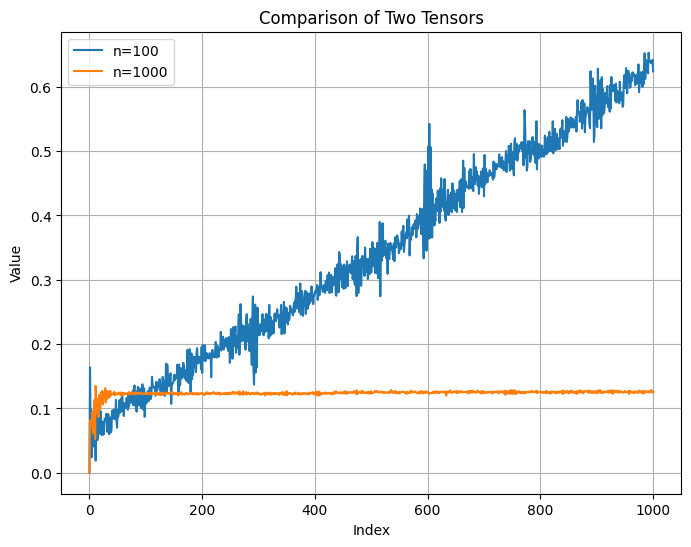

In [11]:
import matplotlib.pyplot as plt
import numpy as np
# Convert tensors to numpy arrays for plotting (optional with PyTorch)
x = np.log(B11_path_sim_1.numpy())
y = np.log(B11_path_sim_2.numpy())

# Plot the curves
plt.figure(figsize=(8, 6))
plt.plot(x, label="n=100")
plt.plot(y, label="n=1000")

# Customize the plot
plt.title("Comparison of Two Tensors")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

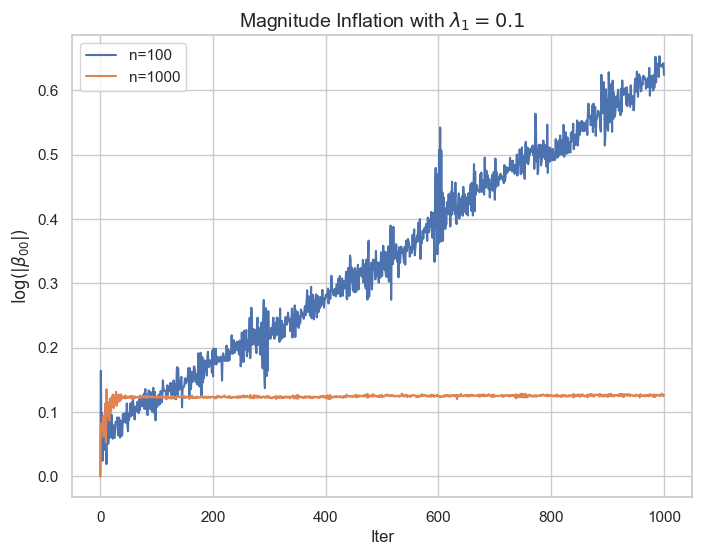

In [17]:
import pandas as pd
import seaborn as sns

# Prepare data for seaborn
data = pd.DataFrame(
    {
        "Index": range(len(B11_path_sim_1)),  # X-axis values
        "sim1": np.log(B11_path_sim_1.numpy()),
        "sim2": np.log(B11_path_sim_2.numpy()),
    }
)

# Create the plot
sns.set_theme(style="whitegrid")  # Set the style
plt.figure(figsize=(8, 6))
sns.lineplot(data=data, x="Index", y="sim1", label=r"$\lambda_1=0.1")
sns.lineplot(data=data, x="Index", y="sim2", label=r"$\lambda_1=0.001")

# Customize the plot
plt.title(r"Magnitude Inflation with $n = 100$", fontsize=14)
plt.xlabel("Iter")
plt.ylabel(r"$\log(|\beta_{00}|)$")
plt.legend()
plt.show()

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from src.simulations.normal_bayesian_factor_dgp import NormalBayesianFactorDGP
from src.sampling.normal_factor_gibbs import SpSlNormalFactorGibbs
from src.utils.setup.create_true_loadings import create_true_loadings

# TODO modify this to have the possibility to set the parameter when running the file

# Force Random Seed
# np.random.seed(42)

# Normal Factor Bayesian Dimensions
num_sim = 100  # small = 100; big = 1000
num_variables = 1956
num_factors = 8

# True Loadings Settings
block_size = 500
overlap = 136
random = False
mean = 1
std = 5

# Hyperparameters
alpha = 1 / num_variables
eta = 1
epsilon = 1
lambda0 = 20


# True Parameters
BTrue = create_true_loadings(
    num_factors=num_factors,
    num_variables=num_variables,
    block_size=block_size,
    overlap=overlap,
    random=random,
    mean=mean,
    std=std,
)

SigmaTrue = np.ones(
    num_variables
)  # TODO define a function to create_true_covariance either random or not

# Initial Latent Parameters
Gamma0 = create_true_loadings(
    num_factors=num_factors,
    num_variables=num_variables,
    block_size=block_size,
    overlap=overlap,
)

Theta0 = np.full((num_factors,), 0.5)

# Simulated Value for Y
DataGeneratingProcess = NormalBayesianFactorDGP(B=BTrue, Sigma=SigmaTrue)

Y_sim = DataGeneratingProcess.simulate(size=num_sim)

# This block ensures multiprocessing works on Windows/macOS
if __name__ == "__main__":

    # Initiate Bayesian Normal Factor Gibbs Sampler
    SparseGibbsSampling1 = SpSlNormalFactorGibbs(
        Y=Y_sim,
        B=BTrue,
        Sigma=SigmaTrue,
        Gamma=Gamma0,
        Theta=Theta0,
        alpha=alpha,
        eta=eta,
        epsilon=epsilon,
        lambda0=lambda0,
        lambda1=0.001,
    )

    # Perform Gibbs Sampler for posterior
    SparseGibbsSampling1.perform_gibbs(iterations=1000, plot=False)
    B11_path_small = SparseGibbsSampling1.get_path()

    SparseGibbsSampling2 = SpSlNormalFactorGibbs(
        Y=Y_sim,
        B=BTrue,
        Sigma=SigmaTrue,
        Gamma=Gamma0,
        Theta=Theta0,
        alpha=alpha,
        eta=eta,
        epsilon=epsilon,
        lambda0=lambda0,
        lambda1=0.1,
    )

    SparseGibbsSampling2.perform_gibbs(iterations=1000, plot=False)
    B11_path_big = SparseGibbsSampling2.get_path()


# Prepare data for seaborn
data = pd.DataFrame(
    {
        "Index": range(len(B11_path_small)),  # X-axis values
        "small": np.log(B11_path_small),
        "big": np.log(B11_path_big),
    }
)

# Create the plot
sns.set_theme(style="whitegrid")  # Set the style
plt.figure(figsize=(8, 6))
sns.lineplot(data=data, x="Index", y="small", label=r"$\lambda_1=0.001")
sns.lineplot(data=data, x="Index", y="big", label=r"$\lambda_1=0.1")

# Customize the plot
plt.title(r"Magnitude Inflation with $n = 100$", fontsize=14)
plt.xlabel("Iter")
plt.ylabel(r"$\log(|\beta_{00}|)$")
plt.legend()
plt.show()

AttributeError: 'SpSlNormalFactorGibbs' object has no attribute 'perform_gibbs_sampling'

In [2]:
import seaborn as sns

KeyboardInterrupt: 

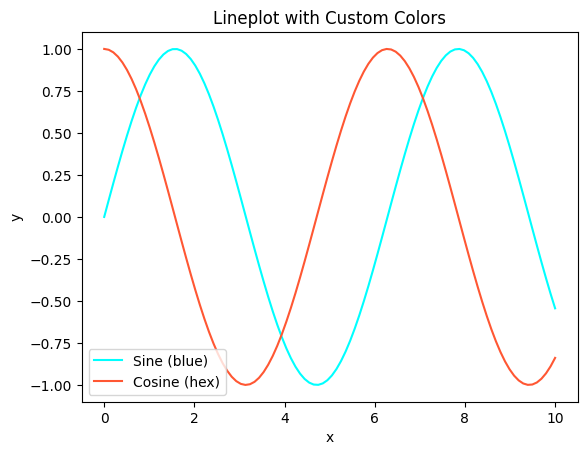

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Example data
x = np.linspace(0, 10, 100)
y1 = np.sin(x)
y2 = np.cos(x)

# Plot with specific colors
sns.lineplot(x=x, y=y1, color="cyan", label="Sine (blue)")
sns.lineplot(x=x, y=y2, color="#FF5733", label="Cosine (hex)")

# Add legend and labels
plt.legend()
plt.title("Lineplot with Custom Colors")
plt.xlabel("x")
plt.ylabel("y")
plt.show()